In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [5]:
folder_path = '/content/drive/MyDrive/EngrKalu/KaluAlibabaNotebooks/cluster-trace-gpu-v2023/csv'
dataframes = []

for filename in os.listdir(folder_path):
    # print(filename)
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
len(dataframes)

26

In [6]:
data = pd.concat(dataframes, ignore_index=True)
data

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time,sn,gpu,model
0,openb-pod-0000,12000,16384,1.0,1000.0,NaN,LS,Running,0.0,12537496.0,0.0,NaN,NaN,NaN
1,openb-pod-0001,6000,12288,1.0,460.0,NaN,LS,Running,427061.0,12902960.0,427061.0,NaN,NaN,NaN
2,openb-pod-0002,12000,24576,1.0,1000.0,NaN,LS,Running,1558381.0,12902960.0,1558381.0,NaN,NaN,NaN
3,openb-pod-0003,6000,12288,1.0,460.0,NaN,LS,Running,2690044.0,12902960.0,2690044.0,NaN,NaN,NaN
4,openb-pod-0004,12000,16384,1.0,1000.0,NaN,LS,Running,2758084.0,12902960.0,2758084.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201928,NaN,104000,524288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1208,2.0,T4
201929,NaN,104000,524288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1209,2.0,T4
201930,NaN,104000,524288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1210,2.0,T4
201931,NaN,96000,393216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1211,8.0,G2


In [7]:
data.isnull().sum()

,0
name,2736
cpu_milli,0
memory_mib,0
num_gpu,2736
gpu_milli,2736
gpu_spec,195241
qos,37375
pod_phase,37375
creation_time,37375
deletion_time,37375


In [8]:
data.describe()

,cpu_milli,memory_mib,num_gpu,gpu_milli,creation_time,deletion_time,scheduled_time,gpu
count,201933.000000,2.019330e+05,199197.000000,199197.000000,1.645580e+05,1.645580e+05,1.458250e+05,2736.000000
mean,11723.857279,4.323071e+04,0.949839,678.128436,1.146626e+07,1.149092e+07,1.144099e+07,4.540936
std,13532.192240,6.175618e+04,0.828167,366.365105,9.626859e+05,9.035249e+05,9.682643e+05,3.226910
min,1000.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,9.538584e+06,0.000000e+00,0.000000
25%,4000.000000,1.525800e+04,1.000000,460.000000,1.069520e+07,1.070431e+07,1.066806e+07,2.000000
50%,11300.000000,4.156000e+04,1.000000,810.000000,1.147048e+07,1.148005e+07,1.141606e+07,2.000000
75%,12000.000000,4.915200e+04,1.000000,1000.000000,1.228024e+07,1.229824e+07,1.225873e+07,8.000000
max,128000.000000,1.048576e+06,8.000000,1000.000000,1.290176e+07,1.290296e+07,1.290176e+07,8.000000


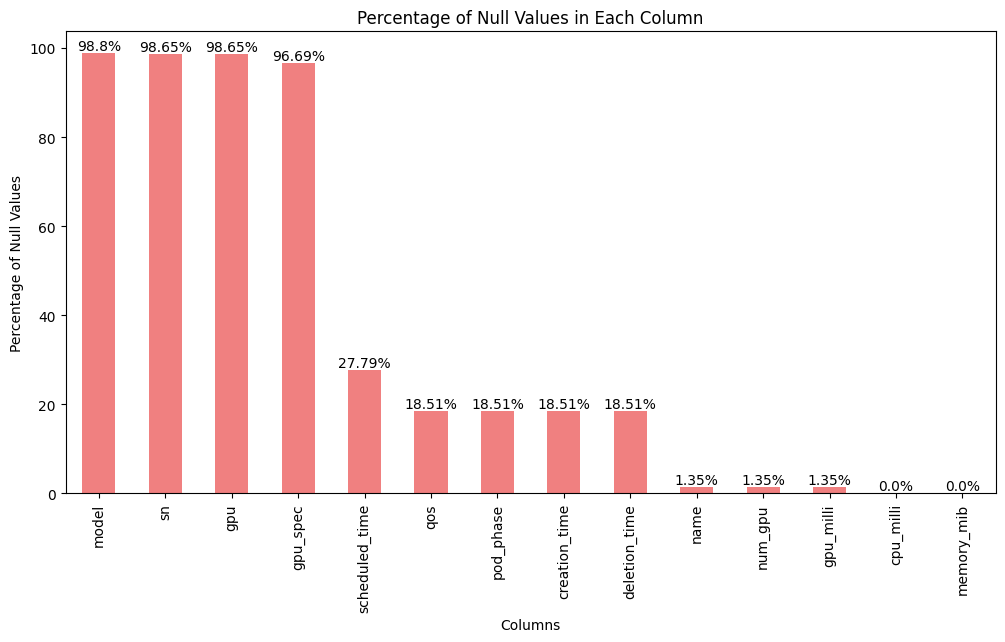

In [9]:
# Calculate the percentage of null values in each column
null_percentage = (data.isnull().mean() * 100).round(2)

# Sort the columns by their null percentage (optional)
null_percentage = null_percentage.sort_values(ascending=False)

# Increase the bar size
plt.figure(figsize=(12, 6))

# Create a bar plot to visualize the null percentages
bars = null_percentage.plot(kind='bar', color='lightcoral')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')

# Add percentage annotations to the top of each bar
for bar, percentage in zip(bars.patches, null_percentage):
    plt.annotate(f'{percentage}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.show()


In [10]:
data.dropna(subset =['scheduled_time'], inplace = True)
data.drop(['sn','gpu','model','gpu_spec'], axis =1, inplace = True)

In [11]:
data

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,qos,pod_phase,creation_time,deletion_time,scheduled_time
0,openb-pod-0000,12000,16384,1.0,1000.0,LS,Running,0.0,12537496.0,0.0
1,openb-pod-0001,6000,12288,1.0,460.0,LS,Running,427061.0,12902960.0,427061.0
2,openb-pod-0002,12000,24576,1.0,1000.0,LS,Running,1558381.0,12902960.0,1558381.0
3,openb-pod-0003,6000,12288,1.0,460.0,LS,Running,2690044.0,12902960.0,2690044.0
4,openb-pod-0004,12000,16384,1.0,1000.0,LS,Running,2758084.0,12902960.0,2758084.0
...,...,...,...,...,...,...,...,...,...,...
200715,openb-pod-8147,32200,132096,4.0,1000.0,LS,Failed,12326217.0,12326255.0,12326219.0
200716,openb-pod-8148,18708,64512,1.0,1000.0,LS,Running,11415998.0,11416215.0,11416034.0
200717,openb-pod-8149,11400,48128,1.0,1000.0,LS,Running,11097781.0,11104258.0,11097783.0
200718,openb-pod-8150,11400,48128,1.0,1000.0,LS,Running,11386033.0,11386156.0,11386069.0


In [12]:
data.isnull().sum()

,0
name,0
cpu_milli,0
memory_mib,0
num_gpu,0
gpu_milli,0
qos,0
pod_phase,0
creation_time,0
deletion_time,0
scheduled_time,0


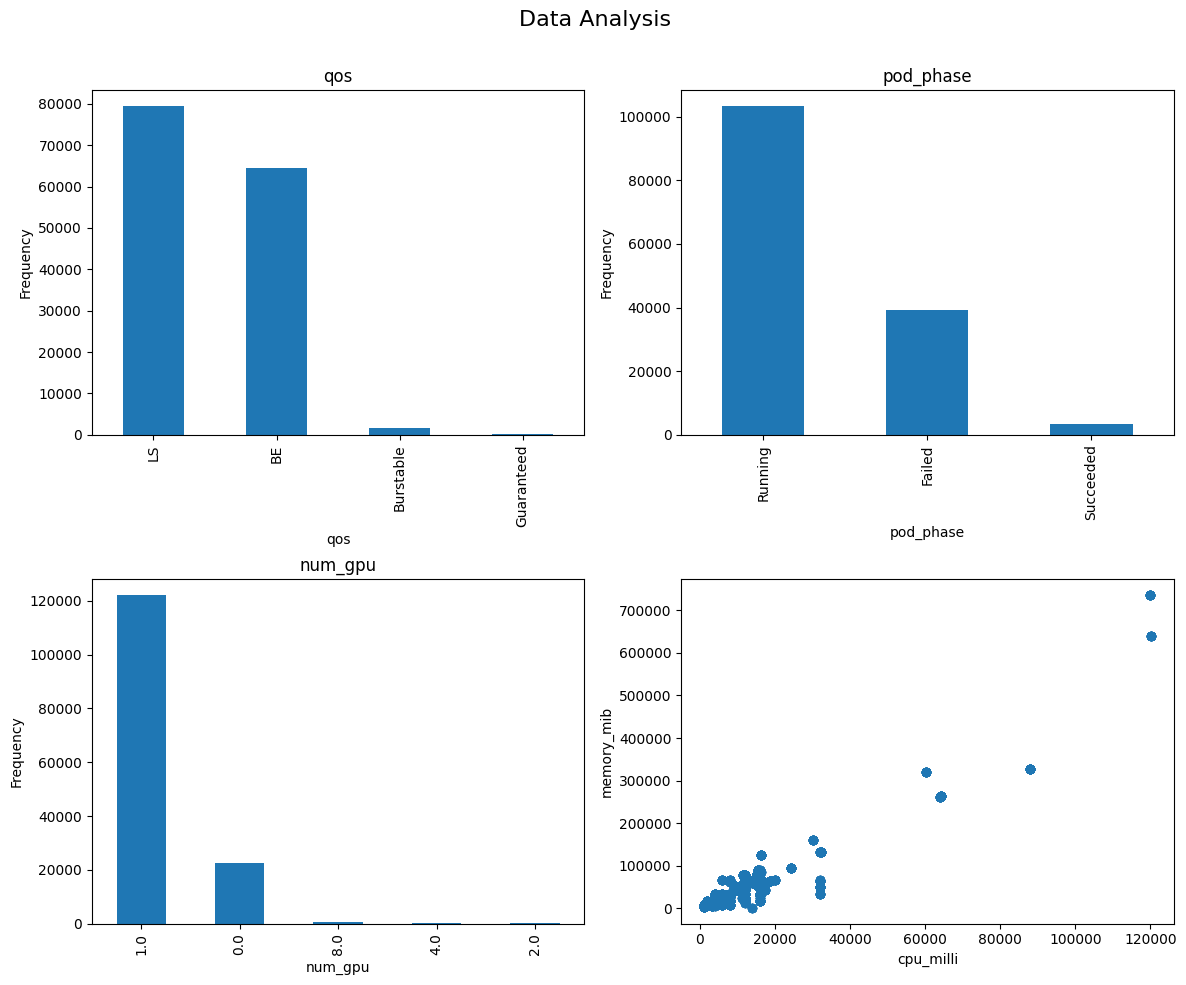

In [13]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms and scatter plot in subplots
data['qos'].value_counts().plot(kind='bar',title='qos', ylabel = 'Frequency', ax=axes[0, 0])
data['pod_phase'].value_counts().plot(kind='bar', title='pod_phase', ylabel = 'Frequency', ax=axes[0, 1])
data['num_gpu'].value_counts().plot(kind='bar', title='num_gpu', ylabel = 'Frequency', ax=axes[1, 0])
data.plot(kind='scatter', x='cpu_milli', y='memory_mib', s=32, alpha=0.8, ax=axes[1, 1])

# Remove top and right spines from all subplots
for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(True)

# Set common titles for the subplots
fig.suptitle('Data Analysis', fontsize=16)

# Adjust layout for better appearance
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the subplots
plt.show()


In [14]:
# Preprocessing
# Encode categorical features
label_encoder = LabelEncoder()
# data['name'] = label_encoder.fit_transform(data['name'])
data['qos'] = label_encoder.fit_transform(data['qos'])
data['pod_phase'] = label_encoder.fit_transform(data['pod_phase'])
data

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,qos,pod_phase,creation_time,deletion_time,scheduled_time
0,openb-pod-0000,12000,16384,1.0,1000.0,3,1,0.0,12537496.0,0.0
1,openb-pod-0001,6000,12288,1.0,460.0,3,1,427061.0,12902960.0,427061.0
2,openb-pod-0002,12000,24576,1.0,1000.0,3,1,1558381.0,12902960.0,1558381.0
3,openb-pod-0003,6000,12288,1.0,460.0,3,1,2690044.0,12902960.0,2690044.0
4,openb-pod-0004,12000,16384,1.0,1000.0,3,1,2758084.0,12902960.0,2758084.0
...,...,...,...,...,...,...,...,...,...,...
200715,openb-pod-8147,32200,132096,4.0,1000.0,3,0,12326217.0,12326255.0,12326219.0
200716,openb-pod-8148,18708,64512,1.0,1000.0,3,1,11415998.0,11416215.0,11416034.0
200717,openb-pod-8149,11400,48128,1.0,1000.0,3,1,11097781.0,11104258.0,11097783.0
200718,openb-pod-8150,11400,48128,1.0,1000.0,3,1,11386033.0,11386156.0,11386069.0


In [15]:
data['qos'].unique()

array([3, 1, 0, 2])

In [16]:
# Normalize numerical features
scaler = StandardScaler()
numerical_cols = list(data.columns)[1:]
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data = data.iloc[:, 1:]

In [17]:
data

,cpu_milli,memory_mib,num_gpu,gpu_milli,qos,pod_phase,creation_time,deletion_time,scheduled_time
0,0.203035,-0.574410,0.167927,0.872779,0.911643,0.509785,-11.816116,1.184439,-11.816016
1,-0.496126,-0.697252,0.167927,-0.570930,0.911643,0.509785,-11.375050,1.589454,-11.374957
2,0.203035,-0.328726,0.167927,0.872779,0.911643,0.509785,-10.206630,1.589454,-10.206553
3,-0.496126,-0.697252,0.167927,-0.570930,0.911643,0.509785,-9.037856,1.589454,-9.037794
4,0.203035,-0.574410,0.167927,0.872779,0.911643,0.509785,-8.967585,1.589454,-8.967524
...,...,...,...,...,...,...,...,...,...
200715,2.556877,2.895867,4.771498,0.872779,0.911643,-1.566560,0.914320,0.950337,0.914248
200716,0.984697,0.868980,0.167927,0.872779,0.911643,0.509785,-0.025748,-0.058190,-0.025772
200717,0.133119,0.377613,0.167927,0.872779,0.911643,0.509785,-0.354400,-0.403908,-0.354455
200718,0.133119,0.377613,0.167927,0.872779,0.911643,0.509785,-0.056695,-0.091502,-0.056719


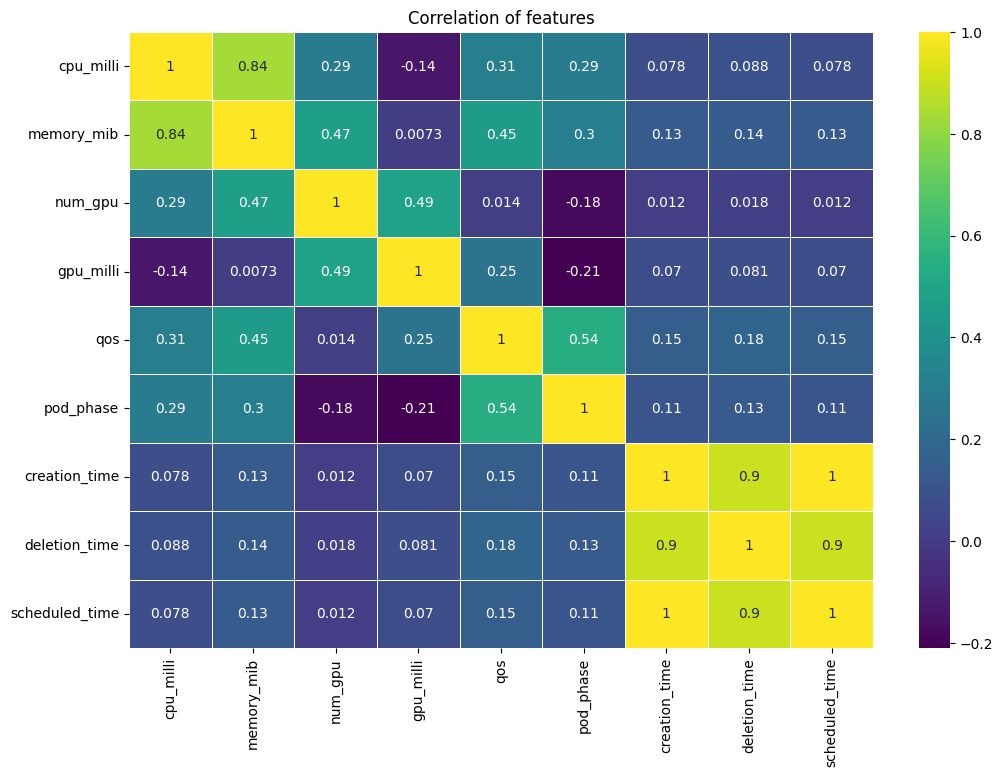

In [18]:
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(),annot=True, cmap='viridis', linewidths=0.5)
plt.title("Correlation of features");

In [38]:
# Split the data
X = data.drop(columns=['memory_mib'])
y = data['memory_mib']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model_ann = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),  # Add dropout layer with a dropout rate of 0.5
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_ann.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Train the model
history_ann = model_ann.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)

# Evaluate the model
loss = model_ann.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

# Make predictions
predictions = model_ann.predict(X_test)


Epoch 1/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5155 - val_loss: 0.1276
Epoch 2/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1793 - val_loss: 0.1122
Epoch 3/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.1466 - val_loss: 0.1055
Epoch 4/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1331 - val_loss: 0.1013
Epoch 5/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1146 - val_loss: 0.1061
Epoch 6/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1060 - val_loss: 0.0993
Epoch 7/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1112 - val_loss: 0.1079
Epoch 8/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0959 - val_loss: 0.1081
Epoch 9/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0962 - val_loss: 0.1186
Epoch 10/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0902 - val_loss: 0.1058
Epoch 11/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0923 - val_loss: 0.1140
Epoch 12/50
1595/1595 ━━━━

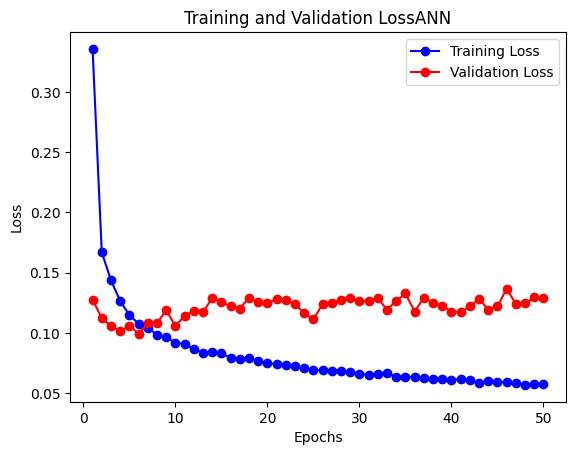

In [22]:
# FUntion to plot the model training history
def history(history, name):
  # Access the training history to get loss values
  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']

  # Create a range of epochs for the x-axis
  epochs = range(1, len(training_loss) + 1)

  # Plot training and validation loss
  plt.plot(epochs, training_loss, label='Training Loss', color='blue', marker='o')
  plt.plot(epochs, validation_loss, label='Validation Loss', color='red', marker='o')

  plt.title(f'Training and Validation Loss{name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


# Scatter plot to visualize actual vs the predicted values

def dataplot(y_test, y_pred, name):
  plt.scatter(y_test, y_pred)
  plt.xlabel("True Values")
  plt.ylabel("Predictions")
  plt.title(f"{name} True_Values vs. Predictions")

  # Add the line of best fit (y = x)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label="Line of Best Fit")

  plt.show()


history(history_ann, "ANN")


In [39]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_ann = model_ann.predict(X_test)
mse = mean_squared_error(y_test, y_pred_ann)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_ann)
print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_ann)
print("R-squared (R²) Score:", r2)

684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Squared Error (MSE): 0.13921567871606158
Root Mean Squared Error (RMSE): 0.37311617321695073
Mean Absolute Error (MAE): 0.21725891751587012
R-squared (R²) Score: 0.8709607186801712


In [24]:
# 684/684 [==============================] - 1s 1ms/step
# Mean Squared Error (MSE): 0.09768265459338259
# Root Mean Squared Error (RMSE): 0.3125422444940565
# Mean Absolute Error (MAE): 0.14769309605157563
# R-squared (R²) Score: 0.9094577589076617

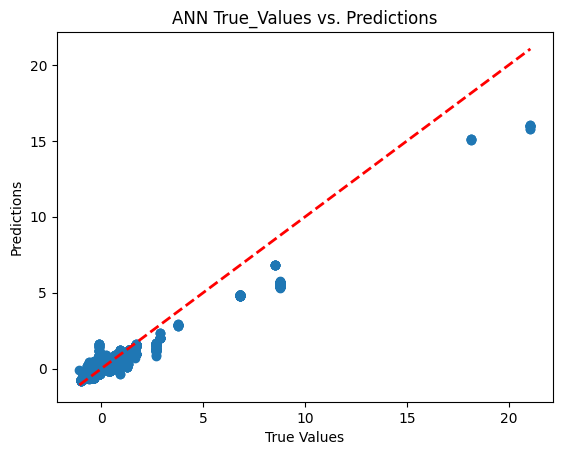

In [25]:
dataplot(y_test, y_pred_ann, "ANN")

In [26]:
# Reshape the input data for the RNN model
import numpy as np

# Convert the DataFrame to a NumPy array
X_train_array = X_train.to_numpy()
X_val_array = X_val.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape the input data for the RNN model
X_train_rnn = np.reshape(X_train_array, (X_train_array.shape[0], X_train_array.shape[1], 1))
X_val_rnn = np.reshape(X_val_array, (X_val_array.shape[0], X_val_array.shape[1], 1))
X_test_rnn = np.reshape(X_test_array, (X_test_array.shape[0], X_test_array.shape[1], 1))




model_rnn = tf.keras.Sequential([
    LSTM(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1)  # Output layer for regression
])

model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_rnn = model_rnn.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val), epochs=50, batch_size=256, callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


399/399 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - loss: 0.7047 - val_loss: 0.2777
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - loss: 0.2003 - val_loss: 0.1120
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.1087 - val_loss: 0.0948
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - loss: 0.0955 - val_loss: 0.0768
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - loss: 0.0760 - val_loss: 0.0689
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/step - loss: 0.0709 - val_loss: 0.0626
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 0.0636 - val_loss: 0.1334
Epoch 8/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.0974 - val_loss: 0.0615
Epoch 9/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0563 - val_loss: 0.0578
Epoch 10/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.0520 - val_loss: 0.0480
Epoch 11/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - loss: 0.0487 - val_loss: 0.0483
Epoch 12/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 

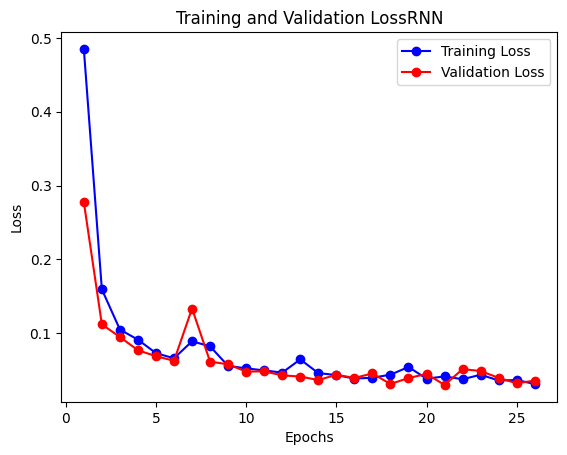

In [27]:
history(history_rnn, "RNN")

In [40]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_rnn = model_rnn.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rnn)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_rnn)
print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_rnn)
print("R-squared (R²) Score:", r2)

684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Mean Squared Error (MSE): 0.02711538003129229
Root Mean Squared Error (RMSE): 0.16466748322389665
Mean Absolute Error (MAE): 0.08030950180160235
R-squared (R²) Score: 0.9748667019101469


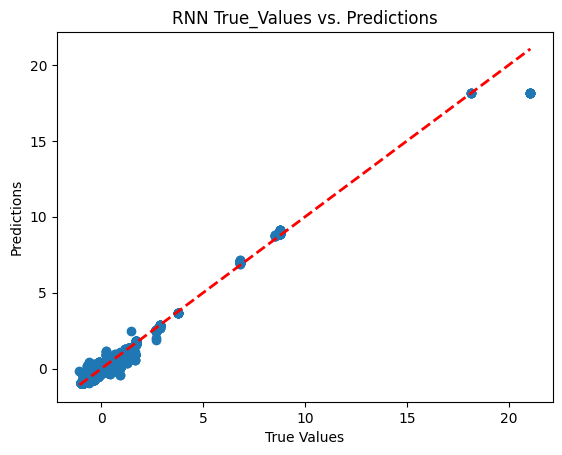

In [29]:
dataplot(y_test, y_pred_rnn, "RNN")

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Assuming you have your data loaded into a DataFrame named 'data'
# Separate the features and target variable
X = data.drop(columns=['memory_mib'])
y = data['memory_mib']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data for the CNN model
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create a CNN model
model_cnn = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=64, validation_data=(X_test_cnn, y_test))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1823/1823 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2390 - val_loss: 0.0874
Epoch 2/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0757 - val_loss: 0.0650
Epoch 3/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0651 - val_loss: 0.0600
Epoch 4/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0610 - val_loss: 0.0577
Epoch 5/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0569 - val_loss: 0.0571
Epoch 6/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0551 - val_loss: 0.0527
Epoch 7/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0549 - val_loss: 0.0524
Epoch 8/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0515 - val_loss: 0.0460
Epoch 9/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0459 - val_loss: 0.0422
Epoch 10/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0438 - val_loss: 0.0416
Epoch 11/50
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0423 - val_loss: 0.0423
Epoch 12/50
1823/1823 ━━━━━━━━━━━━━━━━━━

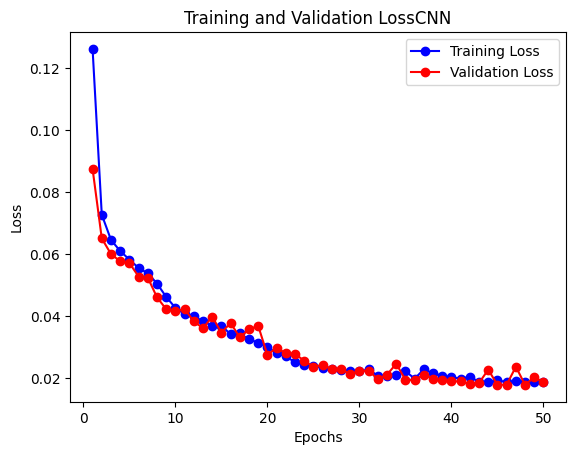

In [31]:
history(history_cnn, "CNN")

In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_cnn = model_cnn.predict(X_test)
mse = mean_squared_error(y_test, y_pred_cnn)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_cnn)
print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_cnn)
print("R-squared (R²) Score:", r2)

684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Squared Error (MSE): 0.018295095268765237
Root Mean Squared Error (RMSE): 0.1352593629615534
Mean Absolute Error (MAE): 0.06167686167856586
R-squared (R²) Score: 0.9830422408816881


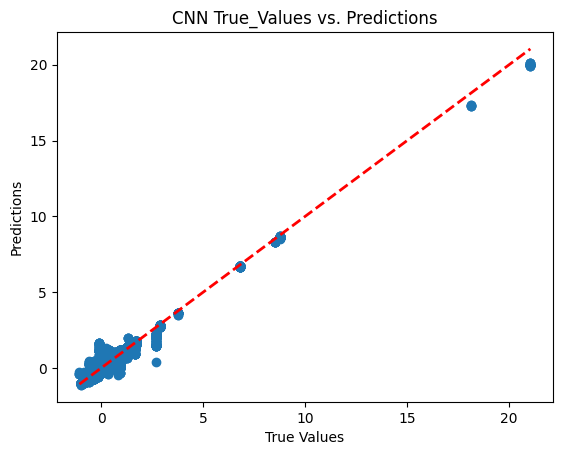

In [33]:
dataplot(y_test, y_pred_cnn, "CNN")

# Ploting the model performance

In [34]:
# Create a dictionary to store the updated model outputs
dict_2 = {
    'Model': ['ANN', 'RNN', 'CNN'],
    'MSE': [0.13228454948470533, 0.015355130268804904, 0.018319219110475776],
    'RMSE': [0.3637094300189443, 0.12391581928391912, 0.13534850981993032],
    'MAE': [0.2062850909867912, 0.05933899011159304, 0.069589073802186],
    'R-squared (R²) Score': [0.8773851957433705, 0.9857673001149523, 0.9826529432607385]
}

# Create a Pandas DataFrame from the updated dictionary
df = pd.DataFrame(dict_2)

# Print the updated DataFrame
df

,Model,MSE,RMSE,MAE,R-squared (R²) Score
0,ANN,0.132285,0.363709,0.206285,0.877385
1,RNN,0.015355,0.123916,0.059339,0.985767
2,CNN,0.018319,0.135349,0.069589,0.982653


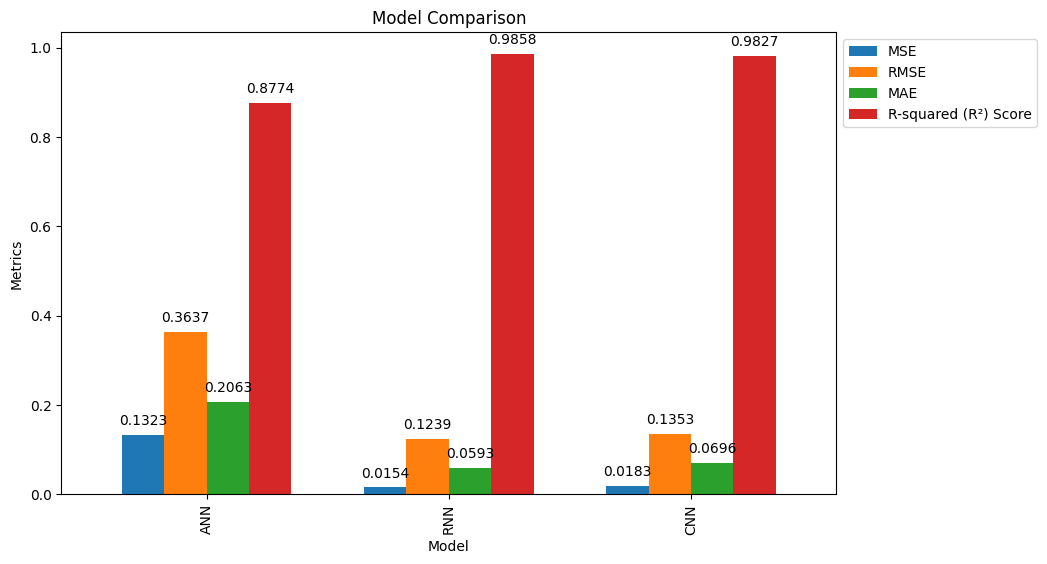

In [35]:
# Create a bar plot with increased bar size and values on top
ax = df.plot(x='Model', y=['MSE', 'RMSE', 'MAE', 'R-squared (R²) Score'], kind='bar', width=0.7, figsize=(10, 6))

plt.title('Model Comparison')
plt.ylabel('Metrics')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Place the legend outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [42]:
y_test.shape, predictions.shape, y_pred_cnn.shape, y_pred_rnn.shape

((21874,), (21874, 1), (21874, 1), (21874, 1))

In [43]:
# Flatten the predictions if they are 2D arrays
predictions_flat = [item[0] for item in predictions]
y_pred_cnn_flat = [item[0] for item in y_pred_cnn]
y_pred_rnn_flat = [item[0] for item in y_pred_rnn]

# Create the DataFrame
result = pd.DataFrame({
    'Actual_values': y_test,
    'y_pred_ann': predictions_flat,
    'y_pred_cnn': y_pred_cnn_flat,
    'y_pred_rnn': y_pred_rnn_flat
})
result

,Actual_values,y_pred_ann,y_pred_cnn,y_pred_rnn
122404,-0.897829,-0.476568,-0.915386,-0.894975
11304,-0.897829,-0.487465,-0.914331,-0.905536
83271,-0.150552,-0.066151,-0.153805,-0.184996
151939,-0.328726,-0.146457,-0.234064,-0.286445
45573,1.728871,1.528437,1.724722,1.785733
...,...,...,...,...
38286,0.868980,0.968372,0.886579,0.862525
87072,0.408324,0.410535,0.427811,0.401956
156064,1.268215,0.465812,1.412378,0.465632
68358,0.346903,0.361856,0.324025,0.289050


In [44]:
result.to_csv('MemoryTrace_Prediction_result.csv', index=False)
# For ANN model
model_ann.save('model_ann_memorytrace.h5')

# For CNN model
model_cnn.save('model_cnn_memorytrace.h5')

# For RNN model
model_rnn.save('model_rnn_memorytrace.h5')
